In [1]:
import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.stats import norm
import seaborn as sns
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d

In [18]:
def divide_data_by_flow_direction(data):
    '''Dividing raw data from one fish into 2 dataframes with either left or right OMR flow'''
    data.columns = ['X_coord', 'Y_coord', 'heading_direction', \
                'cumulative_direction','beat_freq', 'beat_amp', \
                'tail_move?', 'timestamp', 'contrast_level', 'flow_direction']
    right = pd.DataFrame(data[data.flow_direction == 1])
    left = pd.DataFrame(data[data.flow_direction == 2])

    return right, left

def divide_data_by_contrast(data):
    '''Dividing raw data from one fish and one flow direction into contrast levels'''
    C_0 = pd.DataFrame(data[data.contrast_level == 0])
    C_01 = pd.DataFrame(data[data.contrast_level == 0.01])
    C_1 = pd.DataFrame(data[data.contrast_level == 0.1])
    C_2 = pd.DataFrame(data[data.contrast_level == 0.2])
    C_3 = pd.DataFrame(data[data.contrast_level == 0.3])
    C_5 = pd.DataFrame(data[data.contrast_level == 0.5])
    C_7 = pd.DataFrame(data[data.contrast_level == 0.7])
    C_10 = pd.DataFrame(data[data.contrast_level == 1])
    return C_0, C_01, C_1, C_2, C_3, C_5, C_7, C_10

def omr_preprocess(data):
    # remove timestamp and extras
    # keep x, y, heading, cumulative, timestamp
    data.columns = ['X_coord', 'Y_coord', 'heading_direction', \
                'cumulative_direction','beat_freq', 'beat_amp', \
                'tail_move?', 'timestamp', 'contrast_level', 'flow_direction']
    new = data.drop(columns = ['beat_freq', 'beat_amp','tail_move?', 'contrast_level', 'flow_direction'])


    # resetting index
    new = pd.DataFrame(new)
    new = new.set_index('timestamp').reset_index()


    # remove time points where there was an angle change of more than pi from one frame to another
    for i, row in new.iterrows():
        if i+1 == len(new):
            break
            # modify to add the exclusion zone
        if np.abs(new.at[i+1,'cumulative_direction']-new.at[i,'cumulative_direction']) >= 2.8:
            new.at[i+1, 'cumulative_direction'] = new.at[i,'cumulative_direction']


    # interpolating and normalising data to a fixed set of points
    interp = pd.DataFrame(columns=['timestamp','X_coord','Y_coord','heading_direction','cumulative_direction'])
    for column in new.columns:
        x = np.arange(0,len(new))
        y = new[column]
        f = interpolate.interp1d(x,y)

        x_new = np.arange(0,3000,1)
        y_new = f(x_new)
        interp[column] = y_new


    # setting first cumulative_angle to zero and ajdusting all others
    interp.iloc[:,4] -= interp.iloc[0,4]


    # calculating distance traveled between each timeframe
    # distance = sqrt((x2-x1)**2 + (y2-y1)**2)
    interp['distance_pts'] = 0
    for row in range(1,len(interp),1):
        distance = np.sqrt((interp['X_coord'][row]-interp['X_coord'][row-1])**2\
                            +(interp['Y_coord'][row]-interp['Y_coord'][row-1])**2)
        interp.iloc[row,5] = distance


    # cleaning the timestamps
    interp.insert(0, 'new_timestamp', range(1, 1 + len(interp)))
    interp = interp.drop(columns=['timestamp']).rename(columns={'new_timestamp':'timestamp'})
    interp['timestamp'] = interp['timestamp']/1000

    return np.array(interp)

def combine_fish_data(*args):
    '''Combines preprocessed data from all fish into a 3D numpy array'''
    combined_fish = np.stack((args),axis=0)
    return combined_fish



In [ ]:
### fix seconds 

In [19]:
for me in range(1,18):
    exec(f'me{me} = pd.read_csv("../raw_data/AM/Met/xy_hc_fai_tstp_Me_{me}_AM.csv")')
    
for me in range(1,18):
    exec(f'Lme{me},Rme{me} = divide_data_by_flow_direction(me{me})')

for flow in ['R','L']:
    for me in range(1,18):
        exec(f'{flow}me{me}C_0, {flow}me{me}C_01, {flow}me{me}C_1, {flow}me{me}C_2, {flow}me{me}C_3, \
            {flow}me{me}C_5, {flow}me{me}C_7, {flow}me{me}C_10 = divide_data_by_contrast({flow}me{me})')

for flow in ['R','L']:
    for contrast in ['01','1','2','3','5','7','10']:
        for me in range(1,18):
            exec(f'{flow}me{me}C_{contrast} = omr_preprocess({flow}me{me}C_{contrast})')

### Fish with algorithm malfunction or many null values or no data at all:
#### Right Flows:
- Rme5C_01 --> 3 radian jump
- Rme9C_01 --> 3 radian big jumps 
- Rme10C_01 --> massive jumps
- Rme11C_01 --> DISCARD, ridiculous radian measurements
- Rme12C_01 --> massive spikes


- Rme7C_1 --> 3 radian jump
- Rme9C_1 --> 1 big jump + no movement
- Rme11C_2 --> double check
- Rme17C_2 --> NULL VALUES


- Rme8C_3 --> 3 radian jumps
- Rme9C_3 --> 3 radian jumps


- Rme5C_5 --> NO DATA
- Rme8C_5 --> massive jumps
- Rme9C_5 --> 3 radian jumps
- Rme10C_5 --> 1 big jump
- Rme12C_5 --> NO DATA


- Rme5C_7 --> NULL VALUES and big jumps
- Rme8C_7 --> big jumps
- Rme11C_7 --> 3 radian jumps at the end
- Rme12C_7 --> 3 radian jumps


- Rme8C_10 --> massive jumps, impossible final cumul heading
- Rme9C_10 --> only 3 radian jumps
- Rme10C_10 --> wtf is this one???
- Rme12C_10 --> NULL VALUES


#### Left Flows:
- Lme10C_01 --> NULL VALUES

 
- Lme8C_2 --> big jumps
- Lme10C_2 --> big jumps
- Lme11C_2 --> big jumps


- Lme10C_3 --> 1 big jump


- Lme10C_5 --> NO DATA
- Lme12C_5 --> NO DATA
- Lme16C_5 --> big jump


- Lme8C_7 --> massive jumps, impossible
- Lme10C_7 --> 1 big jump
- Lme11C_7 --> NO DATA


- Lme4C_10 --> NULL VALUES
- Lme8C_10 --> 3 radian jumps
- Lme11C_10 --> a few big jumps


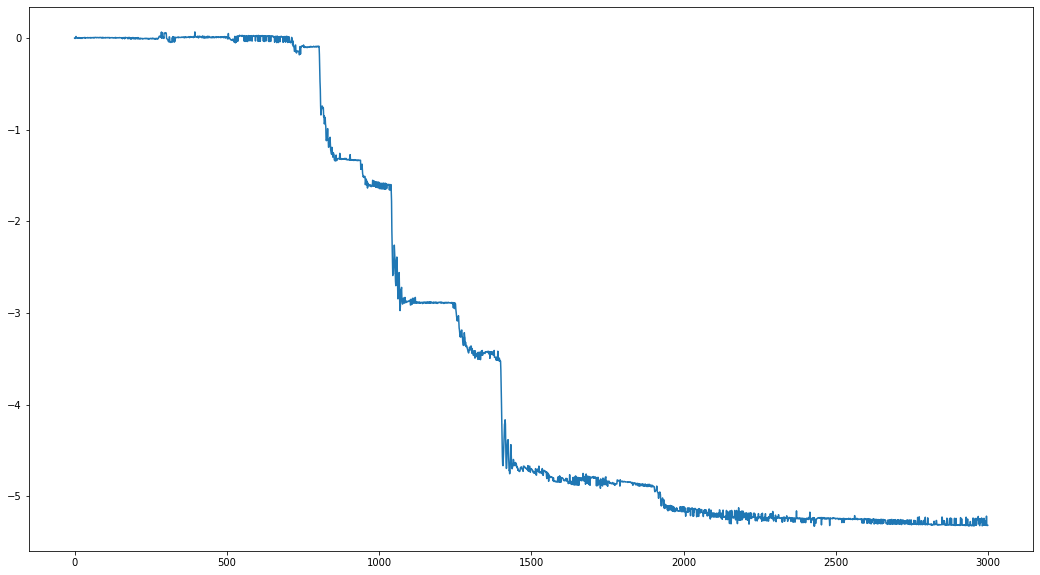

In [38]:
fig, ax = plt.subplots(1,1,figsize=(18,10))
plt.plot(Lme11C_10[:,4])
plt.show()

In [ ]:
comb_LmeC_01 = combine_fish_data(Lme1C_01,Lme2C_01,Lme3C_01,Lme4C_01,Lme5C_01,Lme6C_01,Lme7C_01,Lme8C_01,Lme9C_01,\
                                 Lme10C_01,Lme11C_01,Lme12C_01,Lme13C_01,Lme14C_01,Lme15C_01,Lme16C_01,Lme17C_01)
comb_LmeC_1 = combine_fish_data(Lme1C_1,Lme2C_1,Lme3C_1,Lme4C_1,Lme5C_1,Lme6C_1,Lme7C_1,Lme8C_1,Lme9C_1,\
                                 Lme10C_1,Lme11C_1,Lme12C_1,Lme13C_1,Lme14C_1,Lme15C_1,Lme16C_1,Lme17C_1)
comb_LmeC_2 = combine_fish_data(Lme1C_2,Lme2C_2,Lme3C_2,Lme4C_2,Lme5C_2,Lme6C_2,Lme7C_2,Lme8C_01,Lme9C_2,\
                                 Lme10C_2,Lme11C_2,Lme12C_2,Lme13C_2,Lme14C_2,Lme15C_2,Lme16C_2,Lme17C_2)
comb_LmeC_3 = combine_fish_data(Lme1C_3,Lme2C_3,Lme3C_3,Lme4C_3,Lme5C_3,Lme6C_3,Lme7C_3,Lme8C_3,Lme9C_3,\
                                 Lme10C_3,Lme11C_3,Lme12C_3,Lme13C_3,Lme14C_3,Lme15C_3,Lme16C_3,Lme17C_3)
comb_LmeC_5 = combine_fish_data(Lme1C_5,Lme2C_5,Lme3C_5,Lme4C_5,Lme5C_5,Lme6C_5,Lme7C_5,Lme8C_5,Lme9C_5,\
                                 Lme10C_5,Lme11C_5,Lme12C_5,Lme13C_5,Lme14C_5,Lme15C_5,Lme16C_5,Lme17C_5)
comb_LmeC_7 = combine_fish_data(Lme1C_7,Lme2C_7,Lme3C_7,Lme4C_7,Lme5C_7,Lme6C_7,Lme7C_7,Lme8C_7,Lme9C_7,\
                                 Lme10C_7,Lme11C_7,Lme12C_7,Lme13C_7,Lme14C_7,Lme15C_7,Lme16C_7,Lme17C_7)
comb_LmeC_10 = combine_fish_data(Lme1C_10,Lme2C_10,Lme3C_10,Lme4C_10,Lme5C_10,Lme6C_10,Lme7C_10,Lme8C_10,Lme9C_10,\
                                 Lme10C_10,Lme11C_10,Lme12C_10,Lme13C_10,Lme14C_10,Lme15C_10,Lme16C_10,Lme17C_10)

comb_RmeC_01 = combine_fish_data(Rme1C_01,Rme2C_01,Rme3C_01,Rme4C_01,Rme5C_01,Rme6C_01,Rme7C_01,Rme8C_01,Rme9C_01,\
                                 Rme10C_01,Rme11C_01,Rme12C_01,Rme13C_01,Rme14C_01,Rme15C_01,Rme16C_01,Rme17C_01)
comb_RmeC_1 = combine_fish_data(Rme1C_1,Rme2C_1,Rme3C_1,Rme4C_1,Rme5C_1,Rme6C_1,Rme7C_1,Rme8C_1,Rme9C_1,\
                                 Rme10C_1,Rme11C_1,Rme12C_1,Rme13C_1,Rme14C_1,Rme15C_1,Rme16C_1,Rme17C_1)
comb_RmeC_2 = combine_fish_data(Rme1C_2,Rme2C_2,Rme3C_2,Rme4C_2,Rme5C_2,Rme6C_2,Rme7C_2,Rme8C_01,Rme9C_2,\
                                 Rme10C_2,Rme11C_2,Rme12C_2,Rme13C_2,Rme14C_2,Rme15C_2,Rme16C_2,Rme17C_2)
comb_RmeC_3 = combine_fish_data(Rme1C_3,Rme2C_3,Rme3C_3,Rme4C_3,Rme5C_3,Rme6C_3,Rme7C_3,Rme8C_3,Rme9C_3,\
                                 Rme10C_3,Rme11C_3,Rme12C_3,Rme13C_3,Rme14C_3,Rme15C_3,Rme16C_3,Rme17C_3)
comb_RmeC_5 = combine_fish_data(Rme1C_5,Rme2C_5,Rme3C_5,Rme4C_5,Rme5C_5,Rme6C_5,Rme7C_5,Rme8C_5,Rme9C_5,\
                                 Rme10C_5,Rme11C_5,Rme12C_5,Rme13C_5,Rme14C_5,Rme15C_5,Rme16C_5,Rme17C_5)
comb_RmeC_7 = combine_fish_data(Rme1C_7,Rme2C_7,Rme3C_7,Rme4C_7,Rme5C_7,Rme6C_7,Rme7C_7,Rme8C_7,Rme9C_7,\
                                 Rme10C_7,Rme11C_7,Rme12C_7,Rme13C_7,Rme14C_7,Rme15C_7,Rme16C_7,Rme17C_7)
comb_RmeC_10 = combine_fish_data(Rme1C_10,Rme2C_10,Rme3C_10,Rme4C_10,Rme5C_10,Rme6C_10,Rme7C_10,Rme8C_10,Rme9C_10,\
                                 Rme10C_10,Rme11C_10,Rme12C_10,Rme13C_10,Rme14C_10,Rme15C_10,Rme16C_10,Rme17C_10) 
